In [1]:
from pykp import Knapsack, Item, Sampler
from pykp import solvers
import warnings
import numpy as np
import matplotlib.pyplot as plt
from minizinc import Instance, Model, Solver
from queue import PriorityQueue
from enum import StrEnum, Enum
from typing import Literal
import time

from tqdm import tqdm
import pandas as pd
from collections import defaultdict


In [10]:
np.random.seed(0)
top = 1
n = 15
weights = np.random.randint(1, 10, n)
values = np.random.randint(1, 10, n)
items = np.array([Item(v, w) for v, w in zip(values, weights)])
capacity = int(sum(weights) / 5)

knapsack = Knapsack(items=items, capacity=capacity)
knapsack.solve(solve_all_nodes=True)

solutions = solvers.branch_and_bound(items, capacity, top)

for i in range(top):
	print(solutions[i], knapsack.terminal_nodes[i])
	


(v: 35, w: 16, s: 28928) (v: 35, w: 16, s: 28928)


In [16]:
np.random.seed(0)
top = 20
n = 20
weights = np.random.randint(1, 10, n)
values = np.random.randint(1, 10, n)
items = np.array([Item(v, w) for v, w in zip(values, weights)])
capacity = int(sum(weights) / 5)

solutions = solvers.branch_and_bound(items, capacity, top)
solutions

array([(v: 38, w: 23, s: 1019904), (v: 37, w: 21, s: 1032192),
       (v: 37, w: 22, s: 1024000), (v: 37, w: 23, s: 903168),
       (v: 37, w: 23, s: 970752), (v: 36, w: 22, s: 1018880),
       (v: 36, w: 22, s: 902144), (v: 36, w: 22, s: 974848),
       (v: 36, w: 23, s: 1017344), (v: 36, w: 23, s: 772096),
       (v: 36, w: 23, s: 872448), (v: 36, w: 23, s: 989184),
       (v: 36, w: 23, s: 893952), (v: 35, w: 21, s: 1001472),
       (v: 35, w: 22, s: 969728), (v: 35, w: 22, s: 771072),
       (v: 35, w: 22, s: 999936), (v: 35, w: 22, s: 993280),
       (v: 35, w: 22, s: 876544), (v: 35, w: 22, s: 988160),
       (v: 35, w: 23, s: 991744), (v: 35, w: 23, s: 961536),
       (v: 35, w: 23, s: 741376), (v: 35, w: 23, s: 968192),
       (v: 35, w: 23, s: 762880), (v: 35, w: 23, s: 940032),
       (v: 35, w: 23, s: 508928), (v: 35, w: 23, s: 844800)], dtype=object)

In [2]:
samples = []
nc_list = [0.2, 0.4, 0.6, 0.8]
n_list = [5, 10, 15, 20]
for nc in nc_list:
	for n in n_list:
		sampler = Sampler(
			num_items = n,
			normalised_capacity = nc,
		)
		sample = sampler.sample()
		solution = solvers.mzn_gecode(sample.items, sample.capacity)
		sample.optimal_nodes = np.array([solution])
		samples.append(sample)


samples[0].summary()

C = 0.48683978424996827, nC = 0.2, nTerminal = 32, nOptimal = 1  \
                                                                                                                 1   
v                                                                                             0.26342                
w                                                                                            0.133142                
density                                                                                         1.978                
solution (v = 0.3921767473792429, w = 0.2247259...                                                 IN                

                                                                       \
                                                           2        3   
v                                                   0.128757  0.98703   
w                                                   0.091584  0.85392   
density                                                1.406    1.156   
solution (v = 0.3921767473792429, w = 0.2247259...        IN      OUT   

                                                                        
                                                           4         5  
v                                                   0.566814  0.197886  
w                                                   0.532865  0.822687  
density                                                1.064     0.241  
solution (v = 0.3921767473792429, w = 0.2247259...       OUT       OUT

In [30]:
list(np.array([2, 1]))

[np.int64(2), np.int64(1)]

In [40]:
import json

data = []
for i, sample in enumerate(samples):
	record = {
		"weights": [item.weight for item in sample.items],
		"values": [item.value for item in sample.items],
		"capacity": sample.capacity,
		"optimal_value": sample.optimal_nodes[0].value,
		"optimal_nodes": [
			{
				"weight": node.weight,
				"value": node.value,
				"state": list(node.state)
			} for node in sample.optimal_nodes
		]
	}
	data.append(record)
with open(f"../tests/test_cases.json", "w") as f:
	json.dump(data, f,default = int)




In [3]:
await solvers.mzn_gecode(
	items=np.array([Item(1, 1), Item(2, 2), Item(3, 3), Item(4, 4)]),
	capacity=5
)

(v: 5, w: 5, s: 9)

In [2]:
import pykp.metrics as metrics

grid, phase_transition = metrics.phase_transition(
	num_items=12,
	samples=1000,
	solver="branch_and_bound",
	resolution = (20, 20),
	path="phase_transition.csv"
)

100%|██████████| 400000/400000 [24:27<00:00, 272.55it/s]


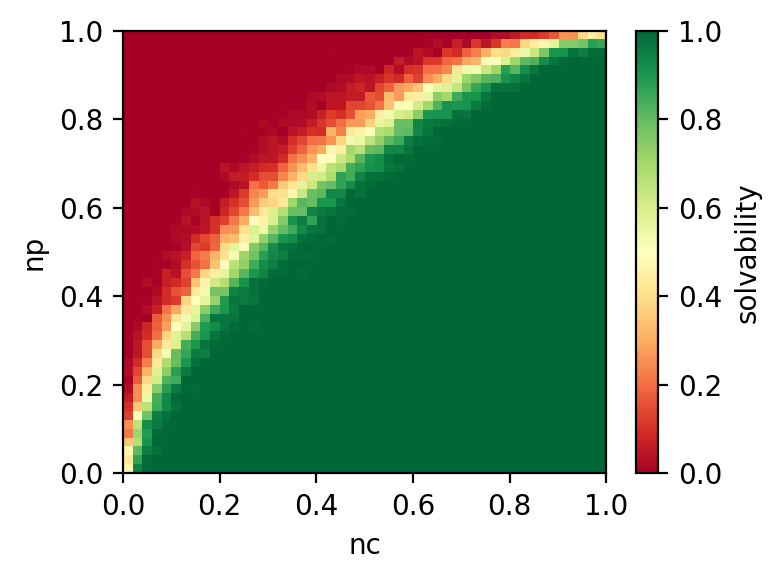

In [6]:
fig, axes = plt.subplots(
	nrows = 1,
	ncols = 1,
	dpi = 200,
	figsize = (4, 3),
	tight_layout = True,
)
image = axes.imshow(
	phase_transition, 
	cmap="RdYlGn", 
	interpolation="nearest",
	# origin="lower",
	aspect="auto",
	extent=(0, 1, 0, 1),
)
axes.set(xlabel="nc", ylabel="np")
cbar = fig.colorbar(image, ax=axes)
cbar.ax.set_ylabel("solvability")
plt.show()

In [5]:
from pykp import Knapsack
from pykp import Item
import pykp.metrics as metrics

items = [
	Item(value=10, weight=5), 
	Item(value=15, weight=10), 
	Item(value=7, weight=3)
]
capacity = 15
knapsack = Knapsack(items=items, capacity=capacity)
await knapsack.solve(method = "mzn_gecode")

display(knapsack.summary())

sahni_k = metrics.sahni_k(knapsack.optimal_nodes[0], capacity)
print(sahni_k)

C = 15, nC = 0.83, nTerminal = 8, nOptimal = 1  \
                                                                              1   
v                                                                             7   
w                                                                             3   
density                                                                   2.333   
solution (v = 25, w = 15, k = 2)                                            OUT   

                                            
                                    2    3  
v                                  10   15  
w                                   5   10  
density                           2.0  1.5  
solution (v = 25, w = 15, k = 2)   IN   IN

2


In [2]:
np.random.seed(2)
for seed in range(5):
	np.random.seed(seed)
	n = 12
	weights = np.random.randint(1, 10, n)
	values = np.random.randint(1, 10, n)
	items = np.array([Item(v, w) for v, w in zip(values, weights)])
	capacity = int(sum(weights) / 2)

	kp = Knapsack(
		items = items,
		capacity = capacity
	)
	solvers = ["branch_and_bound", "mzn_gecode"]
	solutions = []
	for solver in solvers:
		res = await kp.solve(method = solver)
		solutions.append(res[0])
	
	if solutions[0] != solutions[1]:
		print("Different solutions")
		print("Weights: ", weights)
		print("Values: ", values)
		print("Capacity: ", capacity)
		print("Branch and bound: ", solutions[0])
		print("Mzn gecode: ", solutions[1])
		break


In [1]:
state = np.zeros(len(items))
best_item = items[1]
print(items)
print(best_item)

state[np.where(items == best_item)[0][0]] = 1

state

NameError: name 'np' is not defined

In [7]:
weights = np.random.randint(1, 10, 20)
values = np.random.randint(1, 10, 20)

kp = Knapsack(
	items = [Item(v, w) for v, w in zip(values, weights)],
	capacity = sum(weights) / 2
)
print("initialised")
start_time = time.time()
await kp.solve(method="branch_and_bound")
print(f"Time: {time.time() - start_time}")


initialised
Time: 0.028398990631103516


In [16]:
kp.summary()

C = 37.0, nC = 0.5, nTerminal = 1048576, nOptimal = 1  \
                                                                                    1    
v                                                                                 7      
w                                                                                 1      
density                                                                         7.0      
solution (v = 76, w = 37, k = 2)                                                 IN      

                                                                          \
                                   2    3    4     5     6     7      8    
v                                   7    4    9     9     9     9      5   
w                                   1    1    3     4     4     4      3   
density                           7.0  4.0  3.0  2.25  2.25  2.25  1.667   
solution (v = 76, w = 37, k = 2)   IN   IN   IN    IN    IN    IN     IN   

                                                                           \
                                     9      10   11   12   13     14   15   
v                                     4      4    2    3    3      7    4   
w                                     3      3    2    3    3      8    5   
density                           1.333  1.333  1.0  1.0  1.0  0.875  0.8   
solution (v = 76, w = 37, k = 2)     IN     IN   IN  OUT   IN    OUT   IN   

                                                                  
                                    16   17     18     19     20  
v                                    3    2      1      1      1  
w                                    4    5      3      6      8  
density                           0.75  0.4  0.333  0.167  0.125  
solution (v = 76, w = 37, k = 2)   OUT  OUT    OUT    OUT    OUT

In [10]:
start_time = time.time()
solver = BranchAndBound()
result = solver.solve(items = kp.items, capacity = kp.capacity)
print(f"Time: {time.time() - start_time}")
result

Time: 0.02136087417602539


{(v: 69, w: 48, s: 1046208), (v: 69, w: 48, s: 1047232)}

In [3]:
model = Model()
model.add_string(
	"""
    int: n; % number of objects
    set of int: OBJ = 1..n;
    int: capacity;
    array[OBJ] of int: profit;
    array[OBJ] of int: size;

    %var set of OBJ: x;
    array[OBJ] of var 0..1: x;
    var int: TotalProfit=sum(i in OBJ)(profit[i]*x[i]);

    constraint sum(i in OBJ)(size[i]*x[i]) <= capacity;

    solve :: int_search(x, first_fail, indomain_max, complete) maximize TotalProfit;
	"""
)

In [5]:
gecode = Solver.lookup("gecode")

instance = Instance(gecode, model)
instance["n"] = 4
instance["capacity"] = 6.5
instance["profit"] = [3, 4, 3, 8]
instance["size"] = [2, 3, 4, 5]

result = await instance.solve_async()
print(result)

np.array(result["x"])

TypeError: cannot determine coercion from type float to type int

In [4]:
np.random.seed(2)
n = 35
weights = np.random.randint(1, 10, n)
values = np.random.randint(1, 10, n)
items = np.array([Item(v, w) for v, w in zip(values, weights)])
capacity = int(sum(weights) / 2)
solver = MznGecode()

result = await solver.solve(items = items, capacity = capacity)
result

TypeError: Solver.__init__() missing 3 required positional arguments: 'name', 'version', and 'id'

In [1]:
import threading
import queue
import time

q = queue.PriorityQueue()

def worker():
    while True:
        item = q.get()
        print(f'Working on {item}')
        time.sleep(1)
        print(f'Finished {item}')
        q.task_done()

# Turn-on the worker thread.
threading.Thread(target=worker, daemon=True).start()

# Send thirty task requests to the worker.
for item in range(30):
    q.put((item%10, item))

# Block until all tasks are done.
q.join()
print('All work completed')

Working on (0, 0)
Finished (0, 0)
Working on (0, 10)
Finished (0, 10)
Working on (0, 20)
Finished (0, 20)
Working on (1, 1)
Finished (1, 1)
Working on (1, 11)
Finished (1, 11)
Working on (1, 21)
Finished (1, 21)
Working on (2, 2)
Finished (2, 2)
Working on (2, 12)
Finished (2, 12)
Working on (2, 22)
Finished (2, 22)
Working on (3, 3)
Finished (3, 3)
Working on (3, 13)
Finished (3, 13)
Working on (3, 23)
Finished (3, 23)
Working on (4, 4)
Finished (4, 4)
Working on (4, 14)
Finished (4, 14)
Working on (4, 24)
Finished (4, 24)
Working on (5, 5)
Finished (5, 5)
Working on (5, 15)
Finished (5, 15)
Working on (5, 25)
Finished (5, 25)
Working on (6, 6)
Finished (6, 6)
Working on (6, 16)
Finished (6, 16)
Working on (6, 26)
Finished (6, 26)
Working on (7, 7)
Finished (7, 7)
Working on (7, 17)
Finished (7, 17)
Working on (7, 27)
Finished (7, 27)
Working on (8, 8)
Finished (8, 8)
Working on (8, 18)
Finished (8, 18)
Working on (8, 28)
Finished (8, 28)
Working on (9, 9)
Finished (9, 9)
Working on (